In [9]:
import cv2,datetime,os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import IPython.display as Disp

import matplotlib

matplotlib.style.use('ggplot')

In [10]:
os.sys.path.append('roi-code/custom_roi/')
import draw_custom_roi

In [11]:
def order_points(pts):
    """
    pts :np.array
    """
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest cv2sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [12]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    #rect = order_points(pts)
    rect=pts
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

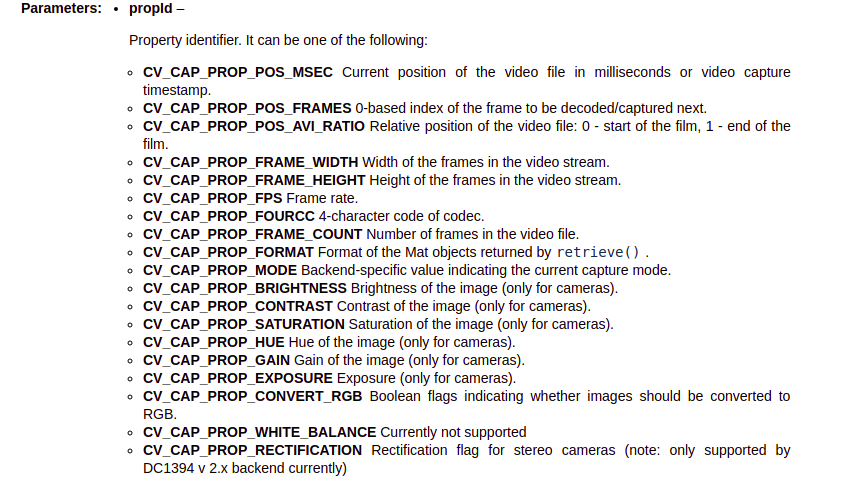

In [13]:
def select_roi(frame):
    """
    select roi in order 
    top-left, top-right, bottom-right, bottom-left
    """
    copy_frame = frame.copy()
    test = draw_custom_roi.define_roi(frame, copy_frame)
    print("selected coordinates: ")
    print(test)
    return np.array(test,dtype=np.float32)
    

In [14]:
def mask_to_objects(mask, threshold,original_image):
    """
    applies a blob detection algorithm to the image
    Args:
        mask: image mask scaled between 0 and 255 
        threshold: min pixel intensity of interest
    Returns:
        list of objects [(x,y)]
    """
    
    params = cv2.SimpleBlobDetector_Params()
    params.minThreshold = threshold
    params.maxThreshold = 255
    
    params.filterByArea = True
    params.minArea = 1000
    params.maxArea = 200000
    
    params.filterByCircularity = False
    params.filterByInertia = True
    params.filterByConvexity = False
    params.filterByColor = False
    params.blobColor = 255

    # Create a detector with the parameters
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3:
        detector = cv2.SimpleBlobDetector(params)
    else: 
        detector = cv2.SimpleBlobDetector_create(params)
    overlay=mask.copy()    
    keypoints = detector.detect(mask)
    
    objects = []
    for k in keypoints:
        cv2.circle(original_image, (int(k.pt[0]), int(k.pt[1])), int(k.size), (0, 0, 255), 2)
        #cv2.line(overlay, (int(k.pt[0])-20, int(k.pt[1])), (int(k.pt[0])+20, int(k.pt[1])), (0,0,0), 3)
        #cv2.line(overlay, (int(k.pt[0]), int(k.pt[1])-20), (int(k.pt[0]), int(k.pt[1])+20), (0,0,0), 3)

    opacity = 0.1
    op=original_image.copy()
    cv2.addWeighted(original_image, opacity, op, 1 - opacity, 0, op)

    # Uncomment to resize to fit output window if needed
    #im = cv2.resize(im, None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
    #plt.imshow( mask)
    #plt.show()
    return op
    
#     for k in keypoints:
#         print(k)
#         x,y,w,h = cv2.boundingRect(k)
#         #objects.append(cv2.rectangle(int(k.pt[0] - k.size), int(k.pt[1] - k.size), int(k.size * 2), int(k.size * 2)))
#         objects.append([x,y,w,h])
#     return objects

In [15]:
def select_min_area(frame):
    """
    select minimum area under which a vehicle can be detected
    """
    bbox1 = cv2.selectROI('select_object', frame)
    return bbox1[2]*bbox1[3]

def running_median(array,q=50,n=5):
    l = len(array)
    return [np.percentile(array[i:i+n],50) for i in range(0,l)]

def num_vehicle(video_channel ,roi=None, plot_intermediate = False, minm_area = None,dump_path=None,remove_shadow=False):
    """
    video_channel : video name or path of video or camera number
    roi : top-left, top-right, bottom-right, bottom-left
    plot_intermediate : plot intermediate plots
    min_area : minimum area that will be used to query
    dump_path : dumping path for congestion and number of vehicles
    remove_shadow : contours will  have no shadow
    
    """
    
    if plot_intermediate:
        cv2.namedWindow('actual',cv2.WINDOW_NORMAL)
        cv2.namedWindow('noise_removal',cv2.WINDOW_NORMAL)
        cv2.namedWindow('non_moving_background',cv2.WINDOW_NORMAL)
        cv2.namedWindow('detected_rectangle',cv2.WINDOW_NORMAL)
        cv2.namedWindow('sure_background',cv2.WINDOW_NORMAL)
        cv2.namedWindow('warped_im',cv2.WINDOW_NORMAL)
        


    #fgbg_mog = cv2.bgsegm.createBackgroundSubtractorMOG(128)
    fgbg_mog2 = cv2.createBackgroundSubtractorMOG2(10,cv2.THRESH_BINARY,1)
    fgbg_gmg = cv2.bgsegm.createBackgroundSubtractorGMG(10, cv2.THRESH_BINARY)
    #blob_det = cv2.SimpleBlobDetector_create()
    #fgbg=cv2.createBackgroundSubtractorKNN(128,cv2.THRESH_BINARY,1)

    #cap =cv2.VideoCapture('test_video_1.mp4')
    cap = cv2.VideoCapture(video_channel)
    #direction of flow is opposite to direction of Y
    #pts=np.array(((210,140),(450,140),(540,300),(0,300)),dtype = np.float32)
    #pts = np.array(((630,200),(970,200),(900,560),(20,560)),dtype = np.float32)
    if roi is None:
        ret,frame = cap.read()
        pts =select_roi(frame)
    else: 
        pts =roi



    #list of ration of sum(contours_area)/total_area
    congestion = []
    # distribution of areas based on histogram
    area_dist = []
    ret = True
    warped_im_area = None
    #w,h= (743, 700)
    w,h = (cap.get(4),cap.get(3))
    #plot=True
    
    text = 'select minimum area object \n skip frame : press s\nconfirmation : press c'
    label = None
    if minm_area is not None:
        min_area_obj_type = str(raw_input("minimum object type? \nbike/car"))

        
    while True:
        try:
            time_1 = datetime.datetime.now()
            ret,frame = cap.read()
            if not (cap.isOpened() and ret):
                break
            if plot_intermediate:
                Disp.clear_output(wait=True)
            #print(cv2.THRESH_BINARY)

            warped_im = four_point_transform(frame,pts)
            
                
                
            while minm_area is None:
                cv2.namedWindow('select_min_area',cv2.WINDOW_NORMAL)
                for idx,i in enumerate(text.split('\n')):
                    cv2.putText(warped_im,i,(10,40*(idx+1)), cv2.FONT_HERSHEY_PLAIN, 1,(0,255,0),1,cv2.LINE_AA)


                k = cv2.waitKey(1)
                cv2.imshow("select_min_area",warped_im)
                if k==115:
                    ##  press s
                    minm_area = None
                    ret,frame = cap.read()
                    warped_im = four_point_transform(frame,pts)
                if k==99:
                    ## press c
                    bbox1 = cv2.selectROI('select_min_area', warped_im)
                    min_area_obj_type = str(raw_input("minimum object type? \nbike/car"))
                    minm_area = bbox1[2]*bbox1[3]
                    cv2.destroyWindow('select_min_area')
                    #print("minimum area selected = "+str(minm_area))


            ret,frame = cap.read()
            #print(str(cap.get(1))+" warping frame")
            warped_im = four_point_transform(frame,pts)
            if warped_im_area is  None:
                warped_im_area = warped_im.shape[0]*warped_im.shape[1]
            #warped_im=frame.copy()
            #plt.figure(figsize=(16,12))
            #plt.imshow(warped_im)
            #plt.show()

            #combining mmog2 and gmg
            fgmask = fgbg_mog2.apply((warped_im))
            if remove_shadow:
                fgmask[fgmask == 127] = 0
            fgmask_gmg = fgbg_gmg.apply((warped_im))

            fgmask=cv2.bitwise_and(fgmask,fgmask_gmg)

        #     fgmask_mog=fgbg_mog.apply((warped_im))
        #     fgmask=cv2.bitwise_and(fgmask,fgmask_mog)    

            # noise removal
            fgmask1=fgmask.copy()
            kernel = np.ones((3,3),np.uint8)
            opening = cv2.morphologyEx(fgmask1,cv2.MORPH_CROSS,kernel,1)
            # sure background area
            sure_bg = cv2.dilate(opening,kernel,iterations=4)
            #cv2.imshow('sure_background',sure_bg)
            #cv2.waitKey(0)

            im2,contours,hierarchy =cv2.findContours(opening,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
            if len(contours)>0:
                #print(str(cap.get(1))+" calculating contour area")
                areas=np.array(list(map(cv2.contourArea,contours)))
                args=np.argwhere(np.array(areas)>minm_area).flatten()
                #print(str(cap.get(1)), args)
                if len(args)>0:
                    #There are multiple frames in  each second...thus each vehicle can be detected twice
                    #hist=np.histogram(areas[args]/warped_im_area,bins=np.array(range(0,100,2),dtype=np.float32)/100)
                    #hist = np.histogram(areas[args],bins=[minm_area,3*minm_area,6*minm_area,20*minm_area])

                    #total area occupied on road
                    #congestion.append([str(time_1) , areas[args].sum()/warped_im_area])
                    if min_area_obj_type == "bike":
                        label=['bike','car','minibus','bus','heavy_duty']
                    if min_area_obj_type == "car":
                        label=['car','minibus','bus','heavy_duty']

                    if plot_intermediate:
                        plt.figure(figsize=(12,6))
                        plt.subplot(121)
                        plt.plot(congestion)
                        plt.subplot(122)
                        #op=plt.hist(areas[args]/warped_im_area)
                        if  min_area_obj_type == 'car':
                            hist_1 = plt.hist(areas[args],\
                                            bins=[0,2*minm_area,4*minm_area,6*minm_area,10*minm_area])[0].tolist()
                            plt.xticks([0,1*minm_area,3*minm_area,5*minm_area,8*minm_area],['','car','minibus','bus','heavy_duty'])
                            plt.show()
                        if min_area_obj_type == 'bike':

                            hist_1 = plt.hist(areas[args],\
                                            bins=[0,2*minm_area,4*minm_area,6*minm_area,8*minm_area,10*minm_area])[0].tolist()

                            plt.xticks([0,1*minm_area,3*minm_area,5*minm_area,7*minm_area,9*minm_area],['','bike','car','minibus','bus','heavy_duty'])
                            plt.show()
                    else :
                        if min_area_obj_type == 'car':
                            hist_1 = np.histogram(areas[args],bins=[0,2*minm_area,4*minm_area,6*minm_area,10*minm_area])[0].tolist()
                        if min_area_obj_type == 'bike':
                            hist_1 = np.histogram(areas[args],bins=[0,2*minm_area,4*minm_area,6*minm_area,8*minm_area,10*minm_area])[0].tolist()

                        #plt.legend([2*minm_area,4*minm_area,6*minm_area,10*minm_area])
                        # area distribution
                        #area_dist.append([str(time_1)] + hist[0].tolist())
                        plt.show()
                    fgmask_rect=fgmask.copy()
                    for arg in args:
                        x,y,w,h = cv2.boundingRect(contours[arg])
                        fgmask_rect=cv2.rectangle(fgmask_rect,(x,y),(x+w,y+h),(255,255,255),2)

                    #diff_image=cv2.subtract(warped_im,fgbg.getBackgroundImage())



                   # blob_im=mask_to_objects(fgmask,.5,warped_im)
                # dumping files
                    if dump_path is not None:
                        #print(cap.get(1),minm_area ,area_dist,congestion)
                        if not os.path.isdir(dump_path):
                            os.makedirs(dump_path)
                        veh_cnt = pd.DataFrame([[str(time_1)] + hist_1],columns = ['timestamp']+label)
                        congestion_df =  pd.DataFrame([[str(time_1) , areas[args].sum()/warped_im_area]],columns=['timestamp','congestion'])
                        if not os.path.isfile(dump_path+'vehicle_count.csv'):
                            veh_cnt.to_csv(dump_path+'/vehicle_count.csv',mode='a+',index=False)
                            congestion_df.to_csv(dump_path+'/congestion.csv',mode = 'a+',index=False)
                        else :
                            veh_cnt.to_csv(dump_path+'/vehicle_count.csv',mode='a+',index=False, header = False)
                            congestion_df.to_csv(dump_path+'/congestion.csv',mode = 'a+',index=False,header = False)

                if plot_intermediate:
                    cv2.imshow('sure_background',sure_bg)
                    cv2.imshow('actual', frame)    
                    cv2.imshow('non_moving_background',fgbg_mog2.getBackgroundImage())
                    cv2.imshow('warped_im',warped_im)
                    cv2.imshow('detected_rectangle',fgmask_rect)
                    cv2.imshow('noise_removal',fgmask)
                    #cv2.imshow('background_difference',diff_image)
                    k = cv2.waitKey(30) & 0xff
                    if k == 27:
                        break


        #return area_dist,congestion
        except Exception as e:
            print(e)
    cap.release()
    cv2.destroyAllWindows()

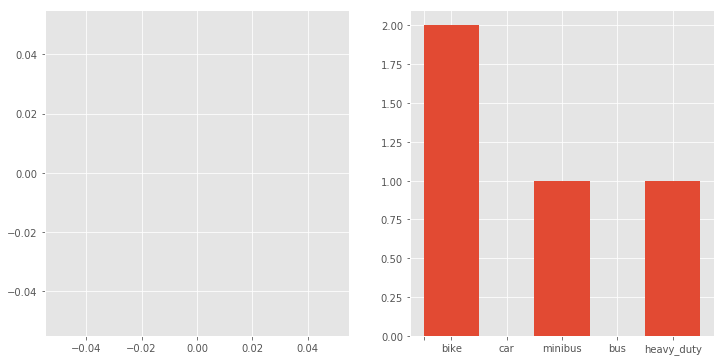

In [16]:
plot_intermediate=True
video_channel = 'akashwani.mp4'
roi= np.array([(620, 150), (892, 228), (681, 623), (27, 471)],dtype = np.float32)
dump_path = 'sample/'
minm_area = 6825

num_vehicle(video_channel,dump_path=dump_path,minm_area=minm_area,roi=roi,plot_intermediate=True)